In [1]:
import numpy as np
import matplotlib.pyplot as plt
from reg_utils import relu, sigmoid, initialize_parameters, load_2D_dataset, compute_cost, predict, predict_dec
from reg_utils import plot_decision_boundary, forward_propagation, backward_propagation, update_parameters
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams["figure.figsize"] = (7.0, 4.0)
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

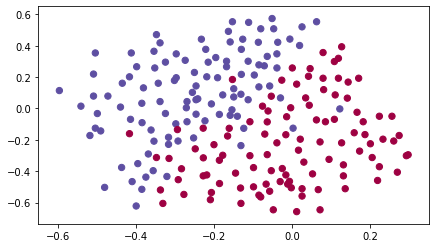

In [2]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## Non-regularized model

In [3]:
def model(X, Y, learning_rate=0.3, num_iterations=30000, print_cost=True, lambd=0, keep_prob=1):
    grads = {}
    costs = []
    m = X.shape[1]
    layers_dims = [X.shape[0], 20, 3, 1]
    
    parameters = initialize_parameters(layers_dims)

    for i in range(0, num_iterations):
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        else:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        assert(lambd == 0 or keep_prob == 1)
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        parameters = update_parameters(parameters, grads, learning_rate)
        
        if i % 10000 == 0:
            costs.append(cost)
            if print_cost:
                print("Cost after iteration {}: {}".format(i, cost))
    
    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("Iterations")
    plt.title("Learning rate: " + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.7122138821631896
Cost after iteration 10000: 0.15529340397988636
Cost after iteration 20000: 0.13033633814147835


/Users/jungyeonkoh/Desktop/Machine_Learning/reg_utils.py:78: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1-a3), 1-Y)
/Users/jungyeonkoh/Desktop/Machine_Learning/reg_utils.py:78: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1-a3), 1-Y)


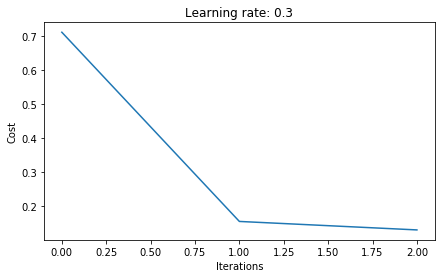

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.945


In [4]:
parameters = model(train_X, train_Y)
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

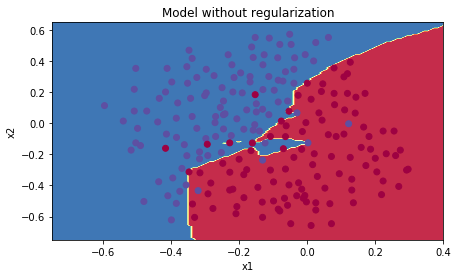

In [5]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## L2 Regularization

In [6]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y)
    L2_regularization_cost = 1/m * lambd / 2 *(np.sum(W1**2) + np.sum(W2**2) + np.sum(W3**2))
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

In [7]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T) + lambd / m * W3
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = 1. / m * np.dot(dZ2, A1.T) + lambd / m * W2
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = 1. / m * np.dot(dZ1, X.T) + lambd / m * W1
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

Cost after iteration 0: 0.7345222724796482
Cost after iteration 10000: 0.2667478216025645
Cost after iteration 20000: 0.2666795803282084


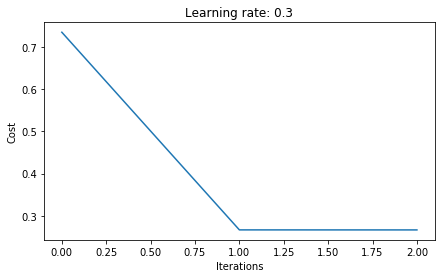

On the training set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.925


In [8]:
parameters = model(train_X, train_Y, lambd = 0.7)
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

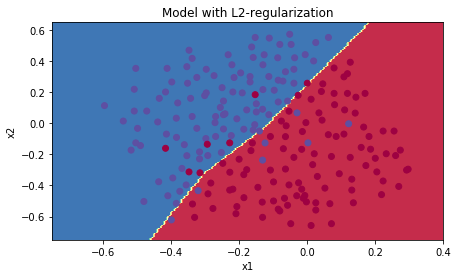

In [9]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## Dropout

In [10]:
def forward_propagation_with_dropout(X, parameters, keep_prob=0.5):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    D1 = np.random.rand(*A1.shape)
    D1 = D1 < keep_prob
    A1 = A1 * D1
    A1 = A1 / keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(*A2.shape)
    D2 = D2 < keep_prob
    A2 = A2 * D2
    A2 = A2 / keep_prob
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    return A3, cache

In [11]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1. / m * np.dot(dZ3, A2.T)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2
    dA2 = dA2 / keep_prob
    dZ2 = np.multiply(dA2, np.int64(A2>0))
    dW2 = 1. / m * np.dot(dZ2, A1.T)
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1
    dA1 = dA1 / keep_prob
    dZ1 = np.multiply(dA1, np.int64(A1>0))
    dW1 = 1. / m * np.dot(dZ1, X.T)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3, "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    return gradients

Cost after iteration 0: 0.6905652487885319
Cost after iteration 10000: 0.21696776693722913


/Users/jungyeonkoh/Desktop/Machine_Learning/reg_utils.py:78: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1-a3), 1-Y)
/Users/jungyeonkoh/Desktop/Machine_Learning/reg_utils.py:78: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(a3), Y) + np.multiply(-np.log(1-a3), 1-Y)


Cost after iteration 20000: 0.19799640163059481


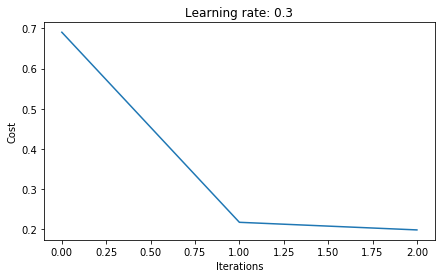

On the training set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.92


In [12]:
parameters = model(train_X, train_Y, keep_prob = 0.8, learning_rate = 0.3)
print("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

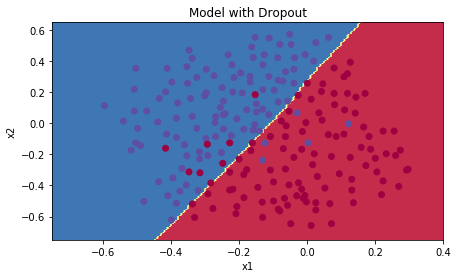

In [13]:
plt.title("Model with Dropout")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)